# Pitchup at $k = 0.7$

In [1]:
using PotentialFlow

In [2]:
using Plots

clibrary(:colorbrewer)
default(clim = (-0.05, 0.05), markerstrokealpha = 0, markersize = 3, grid = false, 
     legend = false, colorbar = :right, colorbar_title = "\$\\Gamma\$")

## Setup

At the beginning of every time-step, we first determine compute the plate kinematics, then the bound vortex sheet strength required to satisfy the no-flow-through condition, and finally velocity of all vortex elements:

In [3]:
function compute_ẋ!(ẋ, x, t)
    plate, ambient_sys = x
    motion = ẋ[1]
    motion.ċ, motion.c̈, motion.α̇ = motion.kin(t)
    
    Plates.enforce_no_flow_through!(plate, motion, ambient_sys, t)
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x, t)
end

compute_ẋ! (generic function with 1 method)

Once we have advected all the vortex elements, we release new segments of the vortex sheet from the edges of the plate.
Since we are dealing with a low angle of attack case, only the trailing edge will be forced to satisfy the Kutta condition.
Vorticity released from the leading edge will instead follow the leading edge suction parameter (LESP) criteria described in [Ramesh et al. 2014](https://doi.org/10.1017/jfm.2014.297).

In [4]:
function shed_new_vorticity!(blobs, plate, motion, t, lesp = 0.0, tesp = 0.0)
    z₊ = (blobs[end-1].z + 2plate.zs[end])/3
    z₋ = (blobs[end].z + 2plate.zs[1])/3
    
    blob₊ = Vortex.Blob(z₊, 1.0, δ)
    blob₋ = Vortex.Blob(z₋, 1.0, δ)
    Plates.enforce_no_flow_through!(plate, motion, blobs, t)
    
    Γ₊, Γ₋, _, _ = Plates.vorticity_flux!(plate, blob₊, blob₋, t, lesp, tesp);
    
    push!(blobs, Vortex.Blob(z₊, Γ₊, blobs[1].δ), Vortex.Blob(z₋, Γ₋, blobs[1].δ))
end

shed_new_vorticity! (generic function with 3 methods)

### Motion Parameters

We start with a plate at around 5ᵒ that smoothly pitches up to 90ᵒ, while moving forward at a constant velocity

In [5]:
L = 1.0 # length of the plate

pitchup = let U₀ = 1,    # Translation velocity
              a  = 0.5,  # Pitching axis (leading edge)
              K = 0.7,   # Pitch rate
              α₀ = 0.0,  # Nominal starting angle
              t₀ = 0.0,  # Nominal starting time
              Δα = π/2,  # Total angle change
              ramp = Plates.RigidBodyMotions.EldredgeRamp(6) # Smooth ramp function
    
    Plates.RigidBodyMotions.Pitchup(U₀, a, K, α₀, t₀, Δα, ramp)
end;

motion = Plates.RigidBodyMotion(pitchup);

### Discretization and Initialization

In [6]:
N = 128
plate = Plate(N, L, zero(ComplexF64), pitchup.α(0))

Δt = 1e-2

δ = 0.01
lesp = 0.2
tesp = 0.0

Δz₀ = im*3Δt*exp(im*plate.α)
z₋, z₊ = plate.zs[[1,N]]

blobs = Vortex.Blob.(Δz₀ .+ [z₊, z₋], 1.0, δ)

Plates.enforce_no_flow_through!(plate, motion, (), 0)
Γ₊, Γ₋, _, _ = Plates.vorticity_flux!(plate, blobs[1], blobs[2], 0.0, lesp, tesp);

blobs = Vortex.Blob.(Δz₀ .+ [z₊, z₋], [Γ₊, Γ₋], δ)

sys₀ = (plate, blobs)

sys = deepcopy(sys₀)
sys₊ = deepcopy(sys₀) # Used for storage during time-marching
ẋs = (motion, allocate_velocity(blobs))

forces = ComplexF64[];

## Time Marching

In [7]:
T = 0.0:Δt:8.0

for t in T
    
    plate, ambient_ω = sys
    motion, ambient_u = ẋs

    resize!(sys₊[2], length(sys[2]))
    forward_euler!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)

    # The force requires information about the motion of the plate,
    # the strength, location, and velocity of the ambient vortex elements,
    # as well as the vorticity flux from the plate edges
    push!(forces, Plates.force(plate, motion, ambient_ω, ambient_u,
            (ambient_ω[end-1], ambient_ω[end]), Δt))

    sys, sys₊ = sys₊, sys
    shed_new_vorticity!(sys[2], sys[1], ẋs[1], t, lesp, tesp)
end


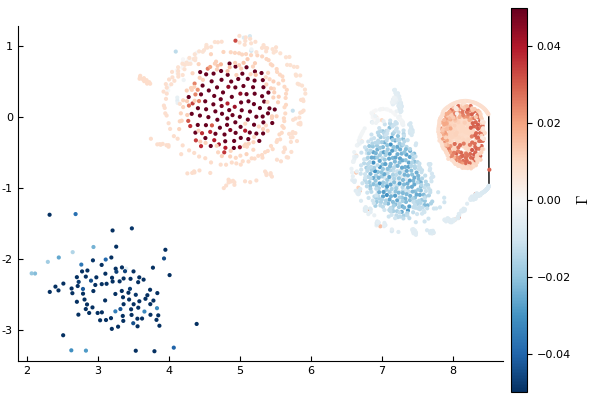

In [8]:
plot(sys, color = :RdBu_r, ratio = 1)


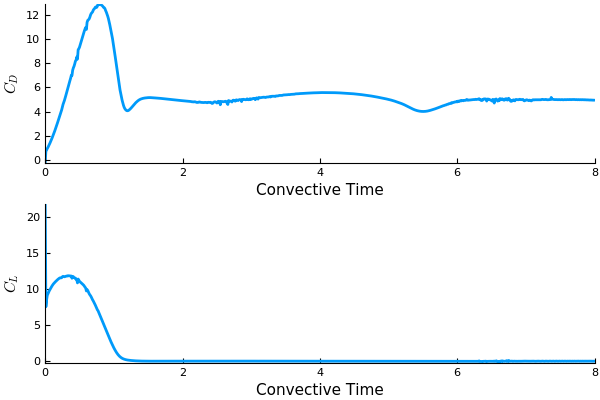

In [9]:
plot(T, [-2real.(forces) 2imag.(forces)], layout = (2,1), linewidth = 2,
     xlabel = "Convective Time", ylabel = ["\$C_D\$" "\$C_L\$"])

### Alternate ramp functions

The `Motion` type has four fields
- `ċ` is the current centroid velocity
- `c̈` is the current centroid acceleration
- `α̇` is the current angular velocity
- `kin` is a function that returns a tuple `(ċ, c̈, α̇)` given an input time

Technically the first three fields are redundunt with the `kin` function, but we don't want to have to carrying around the current time everywhere in our code, so we just use the first three fields as cached values.
In this particular test case, the `kin` function is a `Pitchup` object.  `Pitchup` takes in the tranlational velocity, pitch rate, etc., and also a `ramp` field.  It expects the `ramp` field to be a function that takes in time and returns a smoothed ramp function (with unit nominal slope).  It then composes `ramp` with a time-shifted and negated version of `ramp` to create the pitching profile.

The previous example used a `logcosh` ramp function.  The following example will use a power series based ramp function.

In [10]:
pitchup = let U₀ = 1,    # Translation velocity
              a  = 0.5,  # Pitching axis (leading edge)
              K = 0.7,   # Pitch rate
              α₀ = 0.0,  # Nominal starting angle
              t₀ = 0.0,  # Nominal starting time
              Δα = π/2,  # Total angle change
              ramp = Plates.RigidBodyMotions.ColoniusRamp(4) # Smooth ramp function
    
    Plates.RigidBodyMotions.Pitchup(U₀, a, K, α₀, t₀, Δα, ramp)
end;

motion = Plates.RigidBodyMotion(pitchup);
plate = Plate(N, L, zero(ComplexF64), pitchup.α(0))

sys = (plate, sys₀[2])
sys₊ = deepcopy(sys)
forces = ComplexF64[];

In [11]:
for t in T
    
    plate, ambient_ω = sys
    motion, ambient_u = ẋs

    resize!(sys₊[2], length(sys[2]))
    forward_euler!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)

    # The force requires information about the motion of the plate,
    # the strength, location, and velocity of the ambient vortex elements,
    # as well as the vorticity flux from the plate edges
    push!(forces, Plates.force(plate, motion, ambient_ω, ambient_u,
            (ambient_ω[end-1], ambient_ω[end]), Δt))

    sys, sys₊ = sys₊, sys
    shed_new_vorticity!(sys[2], sys[1], ẋs[1], t, lesp, tesp)
end


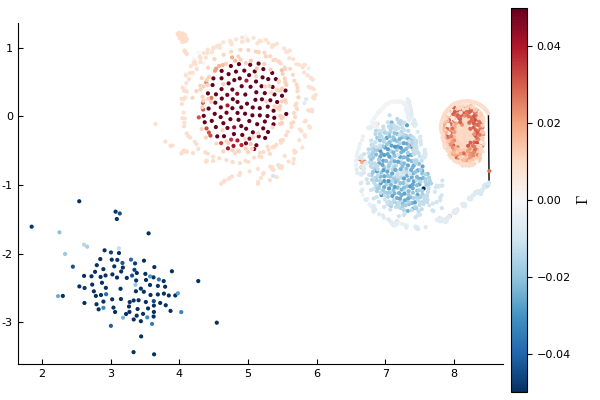

In [12]:
plot(sys, color = :RdBu_r, ratio = 1)


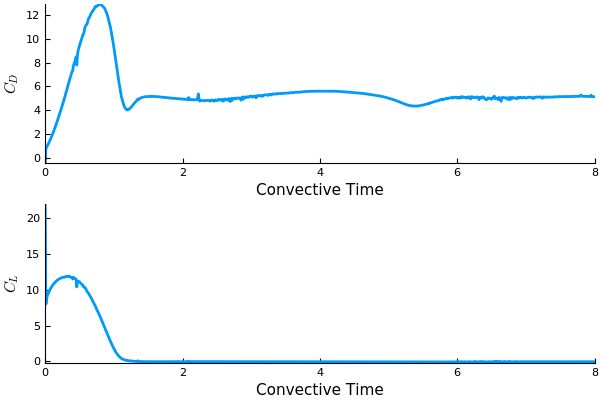

In [13]:
plot(T, [-2real.(forces) 2imag.(forces)], layout = (2,1), linewidth = 2,
     xlabel = "Convective Time", ylabel = ["\$C_D\$" "\$C_L\$"])